<a href="https://colab.research.google.com/github/samsung-chow/324-Project/blob/main/Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import json
from torch.utils.data import DataLoader , TensorDataset
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from typing_extensions import final
import seaborn as sns

import torch.nn.functional as F
from sklearn.model_selection import train_test_split



In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the CSV file; update the filename if needed
df =pd.read_csv("/content/drive/MyDrive/nba/cleaned_data_with_dates.CSV")

df

,team,opponent,attempted_field_goals,attempted_three_point_field_goals,attempted_free_throws,assists,steals,personal_fouls,avg_game_score,percent_fg_made,percent_3p_made,percent_ft_made,ORB,DRB,percent_shots_blocked,TOVR,team_win,opp_win,date
0,12,20,81,30,39,26,8,23,11.033333,0.518519,0.433333,0.717949,0.500000,0.557377,0.016393,0.117112,1,0,140223
1,12,6,82,26,25,22,10,24,8.200000,0.463415,0.423077,0.880000,0.541667,0.466667,0.030303,0.137681,1,0,140327
2,12,24,84,34,33,20,4,20,7.740000,0.404762,0.235294,0.848485,0.250000,0.453333,0.031496,0.056931,0,1,140416
3,12,9,76,24,34,17,6,15,4.950000,0.407895,0.333333,0.647059,0.333333,0.412698,0.008929,0.101594,0,1,140130
4,12,20,92,28,15,26,9,20,6.550000,0.413043,0.285714,0.466667,0.526316,0.436620,0.020408,0.073206,0,1,131121
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8940,24,15,80,34,22,23,7,24,7.100000,0.487500,0.382353,0.818182,0.666667,0.561404,0.000000,0.133165,0,1,151220
8941,24,14,87,30,20,29,3,19,7.538462,0.505747,0.500000,0.600000,0.666667,0.532258,0.030928,0.059791,1,0,150115
8942,24,19,89,21,29,15,4,22,7.730000,0.460674,0.285714,0.758621,0.666667,0.480769,0.000000,0.053946,0,1,151212
8943,24,18,78,27,40,17,4,26,8.670000,0.461538,0.333333,0.900000,0.666667,0.557143,0.028846,0.089153,1,0,160318


In [5]:
df = df.sort_values(by="date")



In [6]:
target_column = [
    'team',
    'opponent',
    'attempted_field_goals',
    'attempted_three_point_field_goals',
    'attempted_free_throws',
    'assists',
    'steals',
    'personal_fouls',
    'avg_game_score',
    'percent_fg_made',
    'percent_3p_made',
    'percent_ft_made',
    'ORB',
    'DRB',
    'percent_shots_blocked',
    'TOVR'
]

# Inputs
X= df[target_column]
# Outputs
y = df['team_win']
scaler = StandardScaler()
training_data = scaler.fit_transform(X)

training_data.shape




(8945, 16)

In [ ]:
X_tensor = torch.tensor(training_data, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.float32)

# Reshape X for 1D CNN: (batch_size, channels=1, sequence_length=14)
X_tensor = X_tensor.unsqueeze(1)


# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Create datasets and loaders
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


X_tensor.shape

torch.Size([8945, 1, 16])

In [ ]:
class CNN1D(nn.Module):
    def __init__(self, n_filters1, n_filters2, fc_size):
        super(CNN1D, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=1, out_channels=n_filters1, kernel_size=3, padding=1)


        self.conv2 = nn.Conv1d(in_channels=n_filters1, out_channels=n_filters2, kernel_size=3, padding=1)

        self.pool = nn.MaxPool1d(kernel_size=2)

        self.fc1 = nn.Linear(n_filters2 * 4, fc_size)
        self.fc2 = nn.Linear(fc_size, 1)  # Final output (e.g., binary classification)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [B, n_filters1, 8]
        x = self.pool(F.relu(self.conv2(x)))  # -> [B, n_filters2, 4]
        x = x.view(x.size(0), -1)             # Flatten -> [B, n_filters2 * 4]
        x = F.relu(self.fc1(x))               # Fully connected layer
        x = self.fc2(x)                       # Output logits
        return x

In [ ]:

model = CNN1D(16, 16, 64)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


for epoch in range(1, 21):
    model.train()
    total_loss = 0.0
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        outputs = model(batch_X).squeeze()

        if torch.isnan(outputs).any():
            #print(" NaNs detected in output!")
            continue

        loss = criterion(outputs, batch_y)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch} , Loss {total_loss:.4f}")
model.eval()
with torch.no_grad():
    logits = model(X_test).squeeze()
    probs = torch.sigmoid(logits)
    preds = (probs > 0.5).float()
    accuracy = (preds == y_test).float().mean()
    print(f" Test Accuracy: {accuracy:.4f}")


Epoch 1 , Loss 118.7756
Epoch 2 , Loss 97.5125
Epoch 3 , Loss 86.2071
Epoch 4 , Loss 82.4433
Epoch 5 , Loss 80.8778
Epoch 6 , Loss 79.6299
Epoch 7 , Loss 79.5143
Epoch 8 , Loss 79.0116
Epoch 9 , Loss 78.2148
Epoch 10 , Loss 78.2396
Epoch 11 , Loss 77.9662
Epoch 12 , Loss 78.3139
Epoch 13 , Loss 76.7794
Epoch 14 , Loss 77.0616
Epoch 15 , Loss 76.4904
Epoch 16 , Loss 76.5956
Epoch 17 , Loss 75.8080
Epoch 18 , Loss 76.4417
Epoch 19 , Loss 75.7285
Epoch 20 , Loss 74.7885
 Test Accuracy: 0.8323


# Hyperparameter Tuning
For both of the models, grid search was used.


Epoch 1, Loss: 118.9781
Epoch 2, Loss: 91.4649
Epoch 3, Loss: 85.0234
Epoch 4, Loss: 82.2370
Epoch 5, Loss: 81.1444
Epoch 6, Loss: 79.6426
Epoch 7, Loss: 79.7877
Epoch 8, Loss: 78.3085
Epoch 9, Loss: 78.3266
Epoch 10, Loss: 77.8181
Epoch 11, Loss: 78.6564
Epoch 12, Loss: 78.0835
Epoch 13, Loss: 77.3678
Epoch 14, Loss: 76.5772
Epoch 15, Loss: 76.9558
Epoch 16, Loss: 76.0920
Epoch 17, Loss: 76.9226
Epoch 18, Loss: 76.6869
Epoch 19, Loss: 76.0274
Epoch 20, Loss: 75.7719
 Test Accuracy: 0.8256
 Accuracy: 0.8256008943543879

 Confusion Matrix:
 [[755 202]
 [110 722]]

 Classification Report:
 {'0.0': {'precision': 0.8728323699421965, 'recall': 0.7889237199582028, 'f1-score': 0.8287596048298573, 'support': 957.0}, '1.0': {'precision': 0.7813852813852814, 'recall': 0.8677884615384616, 'f1-score': 0.8223234624145785, 'support': 832.0}, 'accuracy': 0.8256008943543879, 'macro avg': {'precision': 0.8271088256637389, 'recall': 0.8283560907483322, 'f1-score': 0.8255415336222179, 'support': 1789.0},

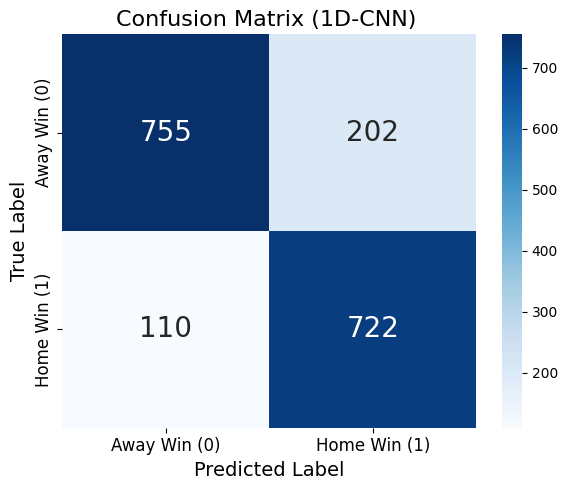

Epoch 1, Loss: 117.9205
Epoch 2, Loss: 93.7303
Epoch 3, Loss: 85.6796
Epoch 4, Loss: 82.2919
Epoch 5, Loss: 81.6847
Epoch 6, Loss: 80.7438
Epoch 7, Loss: 79.6424
Epoch 8, Loss: 79.5082
Epoch 9, Loss: 79.9868
Epoch 10, Loss: 78.9500
Epoch 11, Loss: 77.6863
Epoch 12, Loss: 77.2343
Epoch 13, Loss: 77.5732
Epoch 14, Loss: 76.9474
Epoch 15, Loss: 76.8258
Epoch 16, Loss: 76.2768
Epoch 17, Loss: 76.0885
Epoch 18, Loss: 75.3441
Epoch 19, Loss: 75.6414
Epoch 20, Loss: 74.9290
 Test Accuracy: 0.8345
 Accuracy: 0.8345444382336501

 Confusion Matrix:
 [[820 137]
 [159 673]]

 Classification Report:
 {'0.0': {'precision': 0.8375893769152196, 'recall': 0.8568443051201672, 'f1-score': 0.8471074380165289, 'support': 957.0}, '1.0': {'precision': 0.8308641975308642, 'recall': 0.8088942307692307, 'f1-score': 0.8197320341047503, 'support': 832.0}, 'accuracy': 0.8345444382336501, 'macro avg': {'precision': 0.8342267872230419, 'recall': 0.832869267944699, 'f1-score': 0.8334197360606396, 'support': 1789.0}, 

<Figure size 600x400 with 0 Axes>

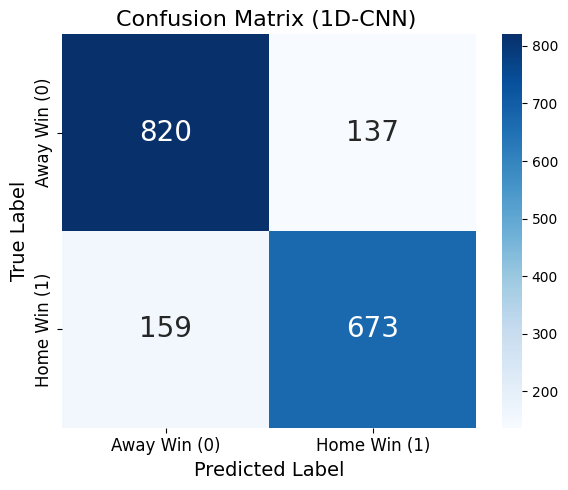

Epoch 1, Loss: 112.6635
Epoch 2, Loss: 89.4527
Epoch 3, Loss: 82.5820
Epoch 4, Loss: 80.6725
Epoch 5, Loss: 80.0774
Epoch 6, Loss: 78.8651
Epoch 7, Loss: 78.3794
Epoch 8, Loss: 77.0298
Epoch 9, Loss: 77.2700
Epoch 10, Loss: 77.6249
Epoch 11, Loss: 77.1525
Epoch 12, Loss: 76.5376
Epoch 13, Loss: 75.6995
Epoch 14, Loss: 75.1940
Epoch 15, Loss: 75.6051
Epoch 16, Loss: 75.5427
Epoch 17, Loss: 74.7450
Epoch 18, Loss: 75.0497
Epoch 19, Loss: 74.4222
Epoch 20, Loss: 74.7185
 Test Accuracy: 0.8256
Epoch 1, Loss: 109.1211
Epoch 2, Loss: 85.4311
Epoch 3, Loss: 81.8360
Epoch 4, Loss: 80.6736
Epoch 5, Loss: 79.7558
Epoch 6, Loss: 79.3475
Epoch 7, Loss: 78.2186
Epoch 8, Loss: 77.4923
Epoch 9, Loss: 77.0075
Epoch 10, Loss: 77.3947
Epoch 11, Loss: 76.2448
Epoch 12, Loss: 75.7272
Epoch 13, Loss: 75.2549
Epoch 14, Loss: 75.5757
Epoch 15, Loss: 74.4180
Epoch 16, Loss: 74.6584
Epoch 17, Loss: 74.2019
Epoch 18, Loss: 73.0695
Epoch 19, Loss: 73.2114
Epoch 20, Loss: 73.1466
 Test Accuracy: 0.8357
 Accuracy:

<Figure size 600x400 with 0 Axes>

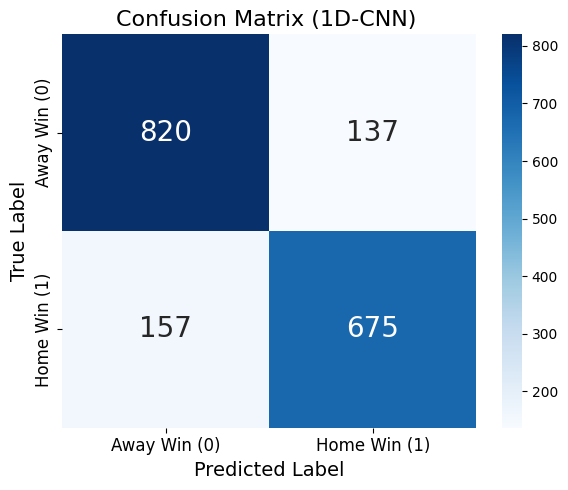

Epoch 1, Loss: 123.5623
Epoch 2, Loss: 103.1483
Epoch 3, Loss: 94.9309
Epoch 4, Loss: 90.7504
Epoch 5, Loss: 87.1978
Epoch 6, Loss: 85.3984
Epoch 7, Loss: 83.1219
Epoch 8, Loss: 81.9552
Epoch 9, Loss: 81.7576
Epoch 10, Loss: 80.7621
Epoch 11, Loss: 80.1862
Epoch 12, Loss: 79.1530
Epoch 13, Loss: 79.2830
Epoch 14, Loss: 78.9167
Epoch 15, Loss: 78.1695
Epoch 16, Loss: 78.8944
Epoch 17, Loss: 78.3291
Epoch 18, Loss: 77.6875
Epoch 19, Loss: 77.5867
Epoch 20, Loss: 77.3440
 Test Accuracy: 0.8362
 Accuracy: 0.8362213527110117

 Confusion Matrix:
 [[824 133]
 [160 672]]

 Classification Report:
 {'0.0': {'precision': 0.8373983739837398, 'recall': 0.8610240334378265, 'f1-score': 0.8490468830499742, 'support': 957.0}, '1.0': {'precision': 0.8347826086956521, 'recall': 0.8076923076923077, 'f1-score': 0.8210140500916311, 'support': 832.0}, 'accuracy': 0.8362213527110117, 'macro avg': {'precision': 0.836090491339696, 'recall': 0.8343581705650671, 'f1-score': 0.8350304665708026, 'support': 1789.0},

<Figure size 600x400 with 0 Axes>

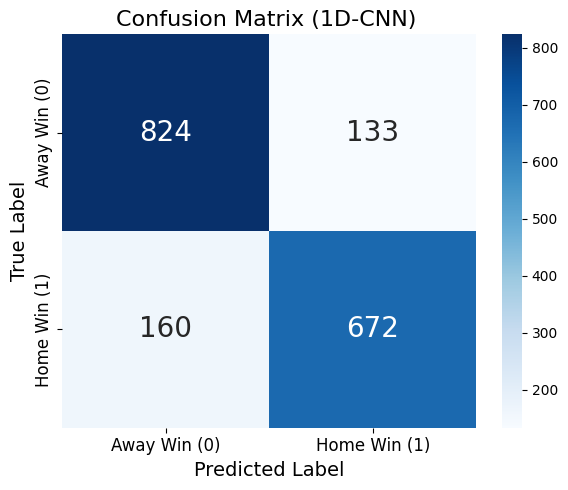

Epoch 1, Loss: 121.0241
Epoch 2, Loss: 101.3768
Epoch 3, Loss: 93.1542
Epoch 4, Loss: 88.6404
Epoch 5, Loss: 87.0365
Epoch 6, Loss: 84.7910
Epoch 7, Loss: 82.9388
Epoch 8, Loss: 83.3919
Epoch 9, Loss: 82.3703
Epoch 10, Loss: 81.5091
Epoch 11, Loss: 80.6663
Epoch 12, Loss: 79.5743
Epoch 13, Loss: 79.9437
Epoch 14, Loss: 79.8547
Epoch 15, Loss: 79.0409
Epoch 16, Loss: 79.1327
Epoch 17, Loss: 78.4316
Epoch 18, Loss: 78.7450
Epoch 19, Loss: 78.3910
Epoch 20, Loss: 78.0126
 Test Accuracy: 0.8295
Epoch 1, Loss: 116.5127
Epoch 2, Loss: 92.9842
Epoch 3, Loss: 87.7061
Epoch 4, Loss: 85.0648
Epoch 5, Loss: 83.8678
Epoch 6, Loss: 81.4355
Epoch 7, Loss: 80.8676
Epoch 8, Loss: 79.9996
Epoch 9, Loss: 79.6392
Epoch 10, Loss: 78.6159
Epoch 11, Loss: 77.7307
Epoch 12, Loss: 77.5567
Epoch 13, Loss: 77.5091
Epoch 14, Loss: 77.1323
Epoch 15, Loss: 77.0393
Epoch 16, Loss: 76.5147
Epoch 17, Loss: 76.3300
Epoch 18, Loss: 75.8197
Epoch 19, Loss: 75.4092
Epoch 20, Loss: 75.3717
 Test Accuracy: 0.8312
Epoch 1, 

<Figure size 600x400 with 0 Axes>

In [ ]:


n_filters1 = [16,8]
n_filters2 = [16,32]
fc_size = [32,64]
lr = [1e-3]



max_accuracy = 0.0
best_params = {"n_filters1" : 0.0, "n_filters2" :0.0, "fc_size" : 0.0, "lr" : 0.0}


for i in range(len(n_filters1)):
    for j in range(len(n_filters2)):
          for l in range(len(fc_size)):
              for m in range(len(lr)):
                  model = CNN1D(n_filters1[i], n_filters2[j], fc_size[l])
                  criterion = nn.BCEWithLogitsLoss()
                  optimizer = torch.optim.Adam(model.parameters(), lr=lr[m])

                  for epoch in range(1, 21):
                    model.train()
                    total_loss = 0.0
                    for batch_X, batch_y in train_loader:


                        optimizer.zero_grad()
                        outputs = model(batch_X).squeeze()


                        if torch.isnan(outputs).any():

                            continue

                        loss = criterion(outputs, batch_y)
                        loss.backward()

                        # Gradient clipping
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

                        optimizer.step()
                        total_loss += loss.item()

                    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

                  model.eval()

                  with torch.no_grad():
                      logits = model(X_test).squeeze()
                      probs = torch.sigmoid(logits)
                      preds = (probs > 0.5).float()
                      accuracy = (preds == y_test).float().mean()
                      print(f" Test Accuracy: {accuracy:.4f}")
                  if accuracy > max_accuracy:
                      y_true = y_test.cpu().numpy()
                      y_pred = preds.cpu().numpy()

                      # Evaluation metrics

                      accuracy = accuracy_score(y_test, y_pred)
                      cm = confusion_matrix(y_test, y_pred)
                      report_dict = classification_report(y_test, y_pred, output_dict=True)
                      report_df = pd.DataFrame(report_dict).transpose()
                      print(" Accuracy:", accuracy)
                      print("\n Confusion Matrix:\n", cm)
                      print("\n Classification Report:\n", report_dict)
                      class_labels = ['Away Win (0)', 'Home Win (1)']
                      plt.figure(figsize=(6, 5))
                      ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                      xticklabels=class_labels, yticklabels=class_labels,
                                      annot_kws={"size": 20})
                      ax.set_xlabel('Predicted Label', fontsize=14)
                      ax.set_ylabel('True Label', fontsize=14)
                      ax.set_title('Confusion Matrix (1D-CNN) ', fontsize=16)
                      plt.xticks(fontsize=12)
                      plt.yticks(fontsize=12)
                      plt.tight_layout()
                      plt.show()
                      max_accuracy = accuracy
                      best_params["n_filters1"] = n_filters1[i]
                      best_params["n_filters2"] = n_filters2[j]
                      best_params["fc_size"] = fc_size[l]
                      best_params["lr"] = lr[m]
                      plt.figure(figsize=(6, 4))



In [ ]:
print("max accuracy" , max_accuracy)
print("best params" , best_params)

max accuracy 0.8362213527110117
best params {'n_filters1': 8, 'n_filters2': 16, 'fc_size': 32, 'lr': 0.001}


#Best Model

In [ ]:
from torchsummary import summary

model = CNN1D(8, 16, 32)
summary(model, (1,16))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1                [-1, 8, 16]              32
         MaxPool1d-2                 [-1, 8, 8]               0
            Conv1d-3                [-1, 16, 8]             400
         MaxPool1d-4                [-1, 16, 4]               0
            Linear-5                   [-1, 32]           2,080
            Linear-6                    [-1, 1]              33
Total params: 2,545
Trainable params: 2,545
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.01
Estimated Total Size (MB): 0.01
----------------------------------------------------------------


# LSTM

In [90]:
target_column = [
    'team',
    'opponent',
    'attempted_field_goals',
    'attempted_three_point_field_goals',
    'attempted_free_throws',
    'assists',
    'steals',
    'personal_fouls',
    'avg_game_score',
    'percent_fg_made',
    'percent_3p_made',
    'percent_ft_made',
    'ORB',
    'DRB',
    'percent_shots_blocked',
    'TOVR'
]

# Inputs
X= df[target_column]
# Outputs
y = df['team_win']
scaler = StandardScaler()
training_data = scaler.fit_transform(X)

training_data.shape




(8945, 16)

In [99]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Scaled training data shape:", X_scaled.shape)  # e.g., (8945, 16)

# Reshape for LSTM input: LSTM expects (samples, timesteps, features).
# Here each sample is a single time step.
X_scaled = X_scaled.reshape(X_scaled.shape[0], 1, X_scaled.shape[1])
print("Reshaped training data shape (for LSTM):", X_scaled.shape)  # e.g., (8945, 1, 16)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32)

print("X_train tensor shape:", X_train_tensor.shape)  # e.g., (7156, 1, 16)
print("X_test tensor shape:", X_test_tensor.shape)

Scaled training data shape: (8945, 16)
Reshaped training data shape (for LSTM): (8945, 1, 16)
X_train tensor shape: torch.Size([7156, 1, 16])
X_test tensor shape: torch.Size([1789, 1, 16])


In [156]:
class SingleOutputLSTM(nn.LSTM):
    def forward(self, input, hx=None):
        output, _ = super().forward(input, hx)
        return output

class LSTMModule(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size=1, dropout=0.0):
        """
        Args:
            input_size (int): Number of features per time step (16 in your case).
            hidden_size (int): Number of features in the LSTM hidden state.
            num_layers (int): Number of LSTM layers.
            output_size (int): Dimension of the output (default 1 for binary classification).
            dropout (float): Dropout probability (applied between LSTM layers if num_layers > 1).
        """
        super(LSTMModule, self).__init__()
        # Use our custom LSTM that returns only the output tensor.
        self.lstm = SingleOutputLSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0
        )
        self.linear = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # x shape: (batch_size, timesteps, input_size)
        lstm_out = self.lstm(x)            # (batch_size, timesteps, hidden_size)
        last_output = lstm_out[:, -1, :]     # (batch_size, hidden_size)
        out = self.linear(last_output)       # (batch_size, output_size)
        return out

In [157]:

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


Training with hidden_size=32, num_layers=1, dropout=0.0, lr=0.001
Epoch 1, Loss: 124.3533
Epoch 2, Loss: 88.4110
Epoch 3, Loss: 79.6107
Epoch 4, Loss: 77.5213
Epoch 5, Loss: 76.8565
Epoch 6, Loss: 76.2641
Epoch 7, Loss: 76.0748
Epoch 8, Loss: 76.0005
Epoch 9, Loss: 75.7666
Epoch 10, Loss: 75.5224
Epoch 11, Loss: 75.2636
Epoch 12, Loss: 74.9952
Epoch 13, Loss: 74.8385
Epoch 14, Loss: 74.7021
Epoch 15, Loss: 74.6459
Epoch 16, Loss: 74.3692
Epoch 17, Loss: 74.0848
Epoch 18, Loss: 74.1359
Epoch 19, Loss: 73.7906
Epoch 20, Loss: 73.9682
Test Accuracy: 0.8385
New Best Configuration Found!
Accuracy: 0.8384572386808273

Confusion Matrix:
 [[799 125]
 [164 701]]

Classification Report:
 {'0.0': {'precision': 0.829698857736241, 'recall': 0.8647186147186147, 'f1-score': 0.8468468468468469, 'support': 924.0}, '1.0': {'precision': 0.8486682808716707, 'recall': 0.8104046242774566, 'f1-score': 0.8290952099349498, 'support': 865.0}, 'accuracy': 0.8384572386808273, 'macro avg': {'precision': 0.8391835

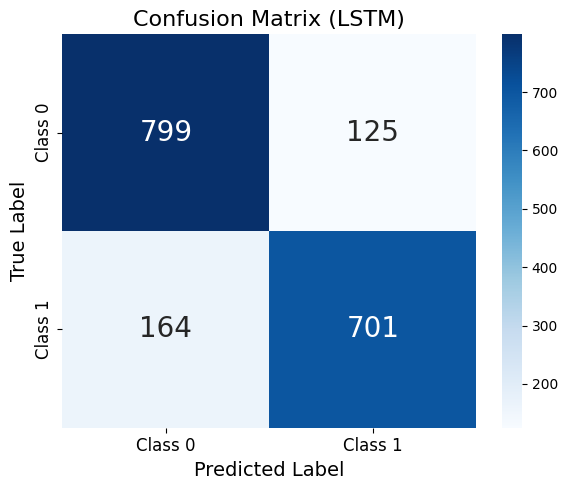


Training with hidden_size=32, num_layers=1, dropout=0.2, lr=0.001
Epoch 1, Loss: 124.9256
Epoch 2, Loss: 88.5529
Epoch 3, Loss: 79.8360
Epoch 4, Loss: 77.6958
Epoch 5, Loss: 77.0029
Epoch 6, Loss: 76.8221
Epoch 7, Loss: 76.2475
Epoch 8, Loss: 76.2692
Epoch 9, Loss: 76.0902
Epoch 10, Loss: 75.6291
Epoch 11, Loss: 75.4506
Epoch 12, Loss: 75.0709
Epoch 13, Loss: 75.1450
Epoch 14, Loss: 75.0735
Epoch 15, Loss: 74.7380
Epoch 16, Loss: 74.5965
Epoch 17, Loss: 74.5788
Epoch 18, Loss: 74.1981
Epoch 19, Loss: 73.9073
Epoch 20, Loss: 74.0384
Test Accuracy: 0.8385

Training with hidden_size=32, num_layers=2, dropout=0.0, lr=0.001
Epoch 1, Loss: 113.3288
Epoch 2, Loss: 79.7232
Epoch 3, Loss: 77.3568
Epoch 4, Loss: 76.6186
Epoch 5, Loss: 76.2796
Epoch 6, Loss: 75.9831
Epoch 7, Loss: 75.5524
Epoch 8, Loss: 75.3789
Epoch 9, Loss: 74.7623
Epoch 10, Loss: 74.5851
Epoch 11, Loss: 74.3493
Epoch 12, Loss: 74.2136
Epoch 13, Loss: 73.7562
Epoch 14, Loss: 73.5386
Epoch 15, Loss: 73.4673
Epoch 16, Loss: 72.9

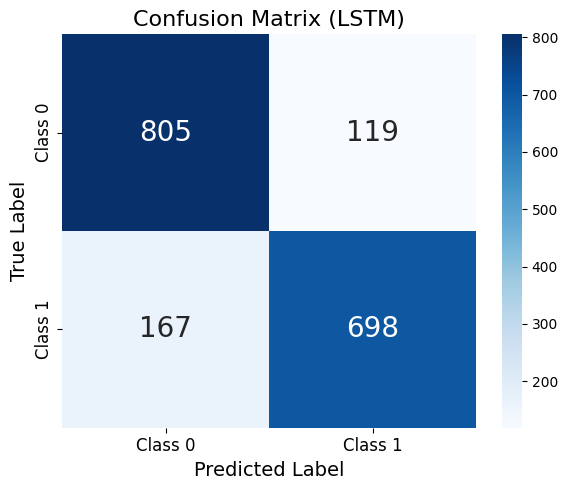


Training with hidden_size=32, num_layers=2, dropout=0.2, lr=0.001
Epoch 1, Loss: 117.1863
Epoch 2, Loss: 81.2014
Epoch 3, Loss: 78.5038
Epoch 4, Loss: 77.8971
Epoch 5, Loss: 77.3865
Epoch 6, Loss: 76.9052
Epoch 7, Loss: 76.3750
Epoch 8, Loss: 76.2868
Epoch 9, Loss: 76.1371
Epoch 10, Loss: 75.7407
Epoch 11, Loss: 76.2053
Epoch 12, Loss: 76.0053
Epoch 13, Loss: 75.4078
Epoch 14, Loss: 75.5001
Epoch 15, Loss: 75.3964
Epoch 16, Loss: 74.9849
Epoch 17, Loss: 75.1922
Epoch 18, Loss: 74.8290
Epoch 19, Loss: 74.4756
Epoch 20, Loss: 74.5059
Test Accuracy: 0.8401

Training with hidden_size=64, num_layers=1, dropout=0.0, lr=0.001
Epoch 1, Loss: 113.3974
Epoch 2, Loss: 81.8526
Epoch 3, Loss: 77.6564
Epoch 4, Loss: 77.0068
Epoch 5, Loss: 76.5962
Epoch 6, Loss: 76.0922
Epoch 7, Loss: 76.2577
Epoch 8, Loss: 75.5543
Epoch 9, Loss: 75.4154
Epoch 10, Loss: 75.3756
Epoch 11, Loss: 75.1513
Epoch 12, Loss: 74.9014
Epoch 13, Loss: 74.6425
Epoch 14, Loss: 74.6088
Epoch 15, Loss: 74.2827
Epoch 16, Loss: 74.0

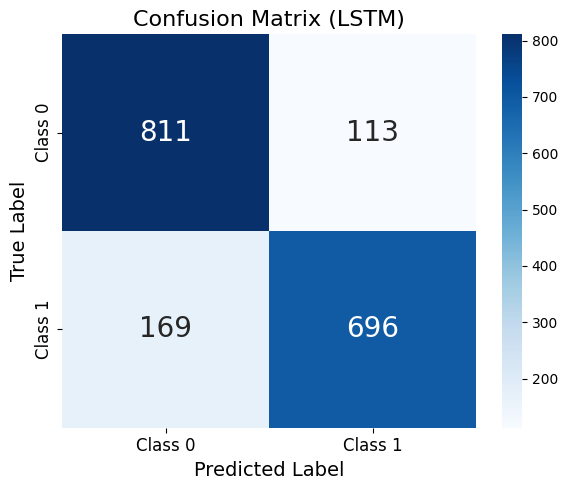


Training with hidden_size=64, num_layers=1, dropout=0.2, lr=0.001
Epoch 1, Loss: 113.3507
Epoch 2, Loss: 82.0479
Epoch 3, Loss: 77.7545
Epoch 4, Loss: 76.6296
Epoch 5, Loss: 76.3542
Epoch 6, Loss: 76.3978
Epoch 7, Loss: 75.9892
Epoch 8, Loss: 75.6073
Epoch 9, Loss: 75.7557
Epoch 10, Loss: 75.4112
Epoch 11, Loss: 75.1215
Epoch 12, Loss: 75.1336
Epoch 13, Loss: 74.7410
Epoch 14, Loss: 74.5873
Epoch 15, Loss: 74.3421
Epoch 16, Loss: 74.1696
Epoch 17, Loss: 73.8655
Epoch 18, Loss: 74.0338
Epoch 19, Loss: 73.5876
Epoch 20, Loss: 73.5440
Test Accuracy: 0.8429
New Best Configuration Found!
Accuracy: 0.8429290106204583

Confusion Matrix:
 [[800 124]
 [157 708]]

Classification Report:
 {'0.0': {'precision': 0.8359456635318704, 'recall': 0.8658008658008658, 'f1-score': 0.8506113769271664, 'support': 924.0}, '1.0': {'precision': 0.8509615384615384, 'recall': 0.8184971098265896, 'f1-score': 0.8344136711844431, 'support': 865.0}, 'accuracy': 0.8429290106204583, 'macro avg': {'precision': 0.843453

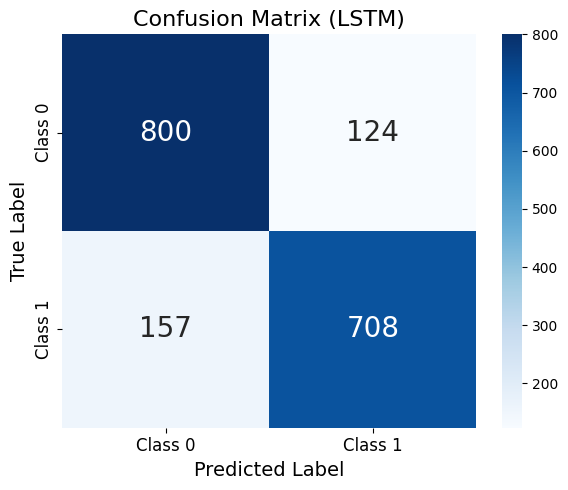


Training with hidden_size=64, num_layers=2, dropout=0.0, lr=0.001
Epoch 1, Loss: 104.4759
Epoch 2, Loss: 78.4412
Epoch 3, Loss: 77.1893
Epoch 4, Loss: 76.6356
Epoch 5, Loss: 76.0190
Epoch 6, Loss: 75.8533
Epoch 7, Loss: 75.1876
Epoch 8, Loss: 75.1342
Epoch 9, Loss: 74.9373
Epoch 10, Loss: 74.2398
Epoch 11, Loss: 74.2299
Epoch 12, Loss: 74.1639
Epoch 13, Loss: 73.6573
Epoch 14, Loss: 73.3287
Epoch 15, Loss: 73.2275
Epoch 16, Loss: 73.0361
Epoch 17, Loss: 72.7126
Epoch 18, Loss: 72.5400
Epoch 19, Loss: 72.0965
Epoch 20, Loss: 71.8394
Test Accuracy: 0.8396

Training with hidden_size=64, num_layers=2, dropout=0.2, lr=0.001
Epoch 1, Loss: 106.0268
Epoch 2, Loss: 79.3759
Epoch 3, Loss: 77.3424
Epoch 4, Loss: 77.3242
Epoch 5, Loss: 76.8689
Epoch 6, Loss: 76.0939
Epoch 7, Loss: 76.0269
Epoch 8, Loss: 75.6113
Epoch 9, Loss: 75.9731
Epoch 10, Loss: 75.6128
Epoch 11, Loss: 75.4624
Epoch 12, Loss: 75.7554
Epoch 13, Loss: 74.6434
Epoch 14, Loss: 74.7640
Epoch 15, Loss: 74.0550
Epoch 16, Loss: 74.1

In [163]:
hidden_sizes    = [32, 64]       # LSTM hidden state sizes
num_layers_list = [1, 2]
dropout_options = [0.0, 0.2]
lr_options      = [1e-3]

max_accuracy = 0.0
best_params = {"hidden_size": None, "num_layers": None, "dropout": None, "lr": None}

input_size = X_train_tensor.shape[2]

# Loop over all combinations of hyperparameters
for hidden_size in hidden_sizes:
    for num_layers in num_layers_list:
        for dropout in dropout_options:
            for lr in lr_options:
                print(f"\nTraining with hidden_size={hidden_size}, num_layers={num_layers}, dropout={dropout}, lr={lr}")

                # Instantiate the model for current hyperparameters
                model = LSTMModule(input_size=input_size, hidden_size=hidden_size,
                                   num_layers=num_layers, output_size=1, dropout=dropout)

                criterion = nn.BCEWithLogitsLoss()
                optimizer = optim.Adam(model.parameters(), lr=lr)

                # Train for 20 epochs
                for epoch in range(1, 21):
                    model.train()
                    total_loss = 0.0
                    for batch_X, batch_y in train_loader:
                        optimizer.zero_grad()
                        outputs = model(batch_X).squeeze()  # shape: (batch_size)

                        # Skip batch if any NaNs encountered
                        if torch.isnan(outputs).any():
                            continue

                        loss = criterion(outputs, batch_y)
                        loss.backward()
                        # Gradient clipping to prevent exploding gradients
                        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
                        optimizer.step()
                        total_loss += loss.item()

                    print(f"Epoch {epoch}, Loss: {total_loss:.4f}")

                # Evaluate the model on test data
                model.eval()
                with torch.no_grad():
                    logits = model(X_test_tensor).squeeze()
                    probs = torch.sigmoid(logits)
                    preds = (probs > 0.5).float()
                    accuracy = (preds == y_test_tensor).float().mean()
                    print(f"Test Accuracy: {accuracy:.4f}")

                # Update best hyperparameters if current configuration is better
                if accuracy > max_accuracy:
                    max_accuracy = accuracy
                    best_params["hidden_size"] = hidden_size
                    best_params["num_layers"] = num_layers
                    best_params["dropout"] = dropout
                    best_params["lr"] = lr

                    # Calculate additional metrics using CPU and numpy
                    y_true = y_test_tensor.cpu().numpy()
                    y_pred = preds.cpu().numpy()

                    acc_val = accuracy_score(y_true, y_pred)
                    cm = confusion_matrix(y_true, y_pred)
                    report_dict = classification_report(y_true, y_pred, output_dict=True)
                    report_df = pd.DataFrame(report_dict).transpose()

                    print("New Best Configuration Found!")
                    print("Accuracy:", acc_val)
                    print("\nConfusion Matrix:\n", cm)
                    print("\nClassification Report:\n", report_dict)

                    # Plot the confusion matrix
                    class_labels = ['Class 0', 'Class 1']  # Update labels as needed
                    plt.figure(figsize=(6, 5))
                    ax = sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                                     xticklabels=class_labels, yticklabels=class_labels,
                                     annot_kws={"size": 20})
                    ax.set_xlabel('Predicted Label', fontsize=14)
                    ax.set_ylabel('True Label', fontsize=14)
                    ax.set_title('Confusion Matrix (LSTM)', fontsize=16)
                    plt.xticks(fontsize=12)
                    plt.yticks(fontsize=12)
                    plt.tight_layout()
                    plt.show()


In [164]:
print("Max accuracy:")
print(max_accuracy)
print("\nBest Hyperparameters:")
print(best_params)

Max accuracy:
tensor(0.8429)

Best Hyperparameters:
{'hidden_size': 64, 'num_layers': 1, 'dropout': 0.2, 'lr': 0.001}


In [167]:
import torch
import torch.nn as nn
from torchsummary import summary
model = LSTMModule(input_size=input_size, hidden_size=64, num_layers=1, output_size=1, dropout=0.2)
summary(model, input_size=(1, 16))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
  SingleOutputLSTM-1                [-1, 1, 64]               0
            Linear-2                    [-1, 1]              65
Total params: 65
Trainable params: 65
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
